In [83]:
import numpy as np 
import open3d as o3d
import os
from natsort import natsorted
from glob import glob
from upsampling_mesh import meshify
from sklearn.neighbors import NearestNeighbors
import ckwrap 
import matplotlib.pyplot as plt
from scipy.io import savemat
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy.linalg import lstsq

o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

def find_neighs(points, k=250):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm= 'kd_tree').fit(points)
    distances, indices = nbrs.kneighbors(points) 
    return distances, indices

def fit_plane(points):
    # print(points.shape)
    dists_ori, indices_ori = find_neighs(points, k=250)
    pcd_neighs = points[indices_ori]
    # print(pcd_neighs.shape)
    norms_arr= []
    for pt in pcd_neighs:
        pca = PCA(n_components=3)
        pca.fit(pt)
        norms_arr.append(pca.components_[2])
    # print("norms_arr shape: ", np.array(norms_arr).shape)
    return norms_arr

def patching(points, normals, radius_chosen):
    dists_ori, indices_ori = find_neighs(points, k=250)
    dists_ori = dists_ori[:, 1:]
    indices_ori = indices_ori[:, 1:]
    
    # Apply ckmeans to all rows and extract labels using a lambda function:
    labels_per_row = np.apply_along_axis(lambda row: ckwrap.ckmeans(row, 5).labels, 1, dists_ori)

    # print("labels_arr shape: ",labels_per_row.shape)  # Now displays the actual labels for each row

    '''
    dists_array has 5 lists within, each list represents a cluster and has 2048 elements.
    '''
    dists_arrays = [[] for _ in np.unique(labels_per_row[0])]
    indices_arrays = [[]for _ in np.unique(labels_per_row[0])]
    for dist, ind, labels in zip(dists_ori, indices_ori, labels_per_row):
        # dist, ind, labels of shapes: (19,)
        for i in  np.unique(labels):
            temp_i = ind[np.where(labels == i)[0]]
            temp_d = dist[np.where(labels == i)[0]]
            dists_arrays[i].append(np.array([temp_d], dtype=object))
            indices_arrays[i].append(np.array([temp_i], dtype=object))
    return dists_arrays, indices_arrays


def visualize_clustered_points(dists_arrays):
    #visualising the clusters

    fig, ax = plt.subplots() 
    colors = ['blue', 'red', 'green', 'purple', 'orange']  
    for i, bucket in enumerate(dists_arrays):
        ax.plot(bucket[0], [i] * len(bucket[0]), '.', color=colors[i], markersize=10)

    plt.xlabel("Data Values")
    plt.ylabel("Cluster Labels")
    plt.title("Clustered Data")
    plt.grid(True)
    plt.show()


In [3]:

pcd_list = np.load('pcd_list.npy')
norm_list = np.load('normals_list2.npy')
print("pcd_list shape: ", pcd_list.shape)
print("norm_list shape: ", norm_list.shape)

    

pcd_list shape:  (16867, 2048, 3)
norm_list shape:  (16867, 2048, 3)


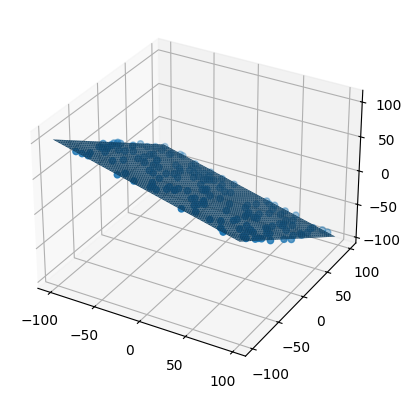

(157, 3)
[0.26726124 0.53452248 0.80178373]
[-0.26726124 -0.53452248 -0.80178373]
-1.0000000000000002


In [15]:
'''
PCA Check
And it works perfectly fine. The normal vector of the plane is the last vector of the pca.components_ array. its either oppositely oriented or correctly oriented.
'''

pts = np.random.randint(-100, 100, size=(100000,3))
abc = np.array([1,2,3])
d = -pts[0].dot(abc)
pts_on_plane = pts[(pts.dot(abc)+d)==0]

#normalise the pts array
# pts_on_plane = pts_on_plane - np.mean(pts_on_plane, axis=0)
# pts_on_plane = pts_on_plane / np.std(pts_on_plane, axis=0)

pca = PCA(n_components=3)
pca.fit(pts_on_plane)

xx, yy = np.meshgrid(np.arange(np.min(pts_on_plane[:, 0]), np.max(pts_on_plane[:, 0])), np.arange(np.min(pts_on_plane[:, 1]), np.max(pts_on_plane[:, 1])))

z = (-abc[0] * xx - abc[1] * yy - d) * 1. / abc[2]

plt3d = plt.figure().add_subplot(projection='3d')
plt3d.plot_surface(xx, yy, z)
plt3d.scatter(*(pts_on_plane.T))
plt.show()

#unit normal vector of the plane
print(pts_on_plane.shape)
abc = abc/np.linalg.norm(abc)
print(abc)
print(pca.components_[2])
print(np.dot(pca.components_[2], abc))

[-5.89950315e-05 -9.99177367e-01  4.05535050e-02] [-0.54960732  0.82187533 -0.14984237]
-0.8272434407451685
[-0.54960729  0.82187536 -0.14984232] [-0.24183519  0.95089835  0.19315296]
dot pdts -0.8272434669899379 -0.9422688135465596
0.024244701265219257 0.19441526865443015 -0.07686329147452943 0.0813170844242586
(16, 18) (16, 18)


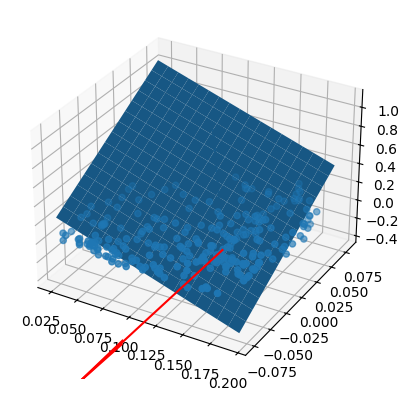

In [88]:
'''
Check PCA for one PCD = pcd_list[5000] - car

Seems to work pretty well with 0.8 as the dot pdt. neg or pos oriented.
'''

def scipy_ls(points):
    a = np.hstack((points[:, :2], np.ones(points.shape[0]).reshape(-1, 1)))
    b= points[:, 2]
    abc, residue, rank, s = lstsq(a, b) 
    return abc

def plane_cost(params, points):
    a, b, c, d = params
    # Compute the signed distances from each point to the plane
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + c * points[:, 2] + d) / np.sqrt(a**2 + b**2 + c**2)
    # Return the sum of squared distances as the cost
    return np.sum(distances**2)

def scipy_min(points):
    ini_guess= np.array([1.0,1.0,1.0,1.0])
    res = minimize(plane_cost, ini_guess, args=(points), method='Nelder-Mead', tol=1e-6)
    return res.x[:3]

pcd = pcd_list[5000]
dists, indices = find_neighs(pcd, 250)
# print(pcd[indices].shape)
neighs = pcd[indices]
points = neighs[0]
pca = PCA(n_components=3)
pca.fit(points)
n_ori = norm_list[5000][0]
n_ori = n_ori/np.linalg.norm(n_ori)
n_esti = pca.components_[2] 
# centroid = np.mean(points, axis=0)
centroid = np.array(pcd[0])
d= -centroid.dot(n_esti)

print(n_ori, n_esti)
print(np.dot(n_ori, n_esti))

#using scipy minimize
n_esti_min = scipy_min(points)

#using scipy lstsq
n_esti_ls = scipy_ls(points)

n_esti_min = n_esti_min/np.linalg.norm(n_esti_min)
n_esti_ls = n_esti_ls/np.linalg.norm(n_esti_ls)
print(n_esti_min, n_esti_ls)
print("dot pdts", n_esti_min.dot(n_ori), n_esti_ls.dot(n_ori))
#plotting surface
xx, yy = np.meshgrid(np.arange(np.min(points[:, 0]), np.max(points[:, 0]), step=0.01), np.arange(np.min(points[:, 1]), np.max(points[:, 1]), step=0.01))
# print(points)
print(np.min(points[:, 0]), np.max(points[:, 0]), np.min(points[:, 1]), np.max(points[:, 1]))
z = (-n_esti[0] * xx - n_esti[1] * yy - d) * 1. / n_esti[2]
print(xx.shape, z.shape)

plt3d = plt.figure().add_subplot(projection='3d')
plt3d.plot_surface(xx, yy, z)
plt3d.quiver(centroid[0], centroid[1], centroid[2], n_esti[0], n_esti[1], n_esti[2], length=0.2, normalize=True)
plt3d.quiver(centroid[0], centroid[1], centroid[2], n_ori[0], n_ori[1], n_ori[2], length=0.2, normalize=True, color='red')
plt3d.scatter(*(points.T))
plt.show()


[ 0.          0.62830373 -0.77796814] [-0.57071306 -0.76902201  0.28790929]
-0.7071636457858159
[ 0.57071305  0.76902202 -0.28790927] [0.51994566 0.46371868 0.71737124]
dot pdts 0.707163640458095 -0.2667357987360623
-0.04114203629672797 0.19441526865443015 -0.07528972288929026 0.14385316597145925
(22, 24) (22, 24)


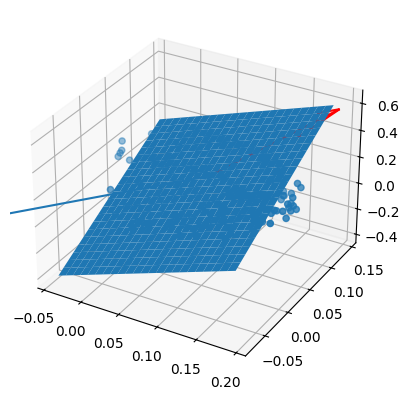

In [101]:
'''
Check PCA for one PCD = pcd_list[5000] - car

Seems to work pretty well with 0.8 as the dot pdt. neg or pos oriented.
'''


def scipy_ls(points):
    a = np.hstack((points[:, :2], np.ones(points.shape[0]).reshape(-1, 1)))
    b= points[:, 2]
    abc, residue, rank, s = lstsq(a, b) 
    return abc

def plane_cost(params, points):
    a, b, c, d = params
    # Compute the signed distances from each point to the plane
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + c * points[:, 2] + d) / np.sqrt(a**2 + b**2 + c**2)
    # Return the sum of squared distances as the cost
    return np.sum(distances**2)

def scipy_min(points):
    ini_guess= np.array([1.0,1.0,1.0,1.0])
    res = minimize(plane_cost, ini_guess, args=(points), method='Nelder-Mead', tol=1e-6)
    return res.x[:3]

pcd = pcd_list[5000]
dists, indices = find_neighs(pcd, 250)
# print(pcd[indices].shape)
neighs = pcd[indices]
points = neighs[1]
pca = PCA(n_components=3)
pca.fit(points)
n_ori = norm_list[5000][1]
n_ori = n_ori/np.linalg.norm(n_ori)
n_esti = pca.components_[2] 
# centroid = np.mean(points, axis=0)
centroid = np.array(pcd[1])
d= -centroid.dot(n_esti)

print(n_ori, n_esti)
print(np.dot(n_ori, n_esti))


#using scipy minimize
n_esti_min = scipy_min(points)

#using scipy lstsq
n_esti_ls = scipy_ls(points)

n_esti_min = n_esti_min/np.linalg.norm(n_esti_min)
n_esti_ls = n_esti_ls/np.linalg.norm(n_esti_ls)
print(n_esti_min, n_esti_ls)
print("dot pdts", n_esti_min.dot(n_ori), n_esti_ls.dot(n_ori))

#plotting surface
xx, yy = np.meshgrid(np.arange(np.min(points[:, 0]), np.max(points[:, 0]), step=0.01), np.arange(np.min(points[:, 1]), np.max(points[:, 1]), step=0.01))
# print(points)
print(np.min(points[:, 0]), np.max(points[:, 0]), np.min(points[:, 1]), np.max(points[:, 1]))
z = (-n_esti[0] * xx - n_esti[1] * yy - d) * 1. / n_esti[2]
print(xx.shape, z.shape)

plt3d = plt.figure().add_subplot(projection='3d')
plt3d.plot_surface(xx, yy, z)
plt3d.quiver(centroid[0], centroid[1], centroid[2], n_esti[0], n_esti[1], n_esti[2], length=0.5, normalize=True)
plt3d.quiver(centroid[0], centroid[1], centroid[2], n_ori[0], n_ori[1], n_ori[2], length=0.5, normalize=True, color='red')
plt3d.scatter(*(points.T))
plt.show()


In [90]:
import multiprocessing 
print(neighs.shape)
print(os.cpu_count())
print(multiprocessing.cpu_count())

(2048, 250, 3)
8
8


In [96]:
'''
doing PCA for all the points in the pcd_list
'''
from joblib import Parallel, delayed
def pca_plane(points):
    # print(points.shape)
    pca = PCA(n_components=3)
    pca.fit(points)
    return pca.components_[2]

def scipy_ls(points):
    a = np.hstack((points[:, :2], np.ones(points.shape[0]).reshape(-1, 1)))
    b= points[:, 2]
    abc, residue, rank, s = lstsq(a, b) 
    return abc/np.linalg.norm(abc)

def plane_cost(params, points):
    a, b, c, d = params
    # Compute the signed distances from each point to the plane
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + c * points[:, 2] + d) / np.sqrt(a**2 + b**2 + c**2)
    # Return the sum of squared distances as the cost
    return np.sum(distances**2)

def scipy_min(points):
    ini_guess= np.array([1.0,1.0,1.0,1.0])
    res = minimize(plane_cost, ini_guess, args=(points), method='Nelder-Mead', tol=1e-6)
    return res.x[:3]/np.linalg.norm(res.x[:3])

norm_esti_pca = Parallel(n_jobs=-1)(delayed(pca_plane)(point_neighs) for point_neighs in neighs)
norm_esti_ls = Parallel(n_jobs=-1)(delayed(scipy_ls)(point_neighs) for point_neighs in neighs)
norm_esti_min = Parallel(n_jobs=-1)(delayed(scipy_min)(point_neighs) for point_neighs in neighs)




0.29965853682252297 -0.0009105846565999002 -0.025424231527029852


In [98]:
dot_pca = np.diag(np.dot(norm_esti_pca, norm_list[5000].T)).mean()
dot_ls = np.diag(np.dot(norm_esti_ls, norm_list[5000].T)).mean()
dot_min = np.diag(np.dot(norm_esti_min, norm_list[5000].T)).mean()

print(dot_pca, dot_ls, dot_min)

dot_pca = np.abs(np.diag(np.dot(norm_esti_pca, norm_list[5000].T))).mean()
dot_ls = np.abs(np.diag(np.dot(norm_esti_ls, norm_list[5000].T))).mean()
dot_min = np.abs(np.diag(np.dot(norm_esti_min, norm_list[5000].T))).mean()

print(dot_pca, dot_ls, dot_min)

-0.007993694959798948 -0.0009105846565999002 -0.025424231527029852
0.29965853682252297 0.2827758271392473 0.30068566004985586


In [100]:
np.diag(np.dot(norm_esti_pca, norm_list[5000].T))

array([-0.82659867, -0.01783885, -0.33314643, ..., -0.72473988,
       -0.92111121, -0.53043117])

In [76]:
ans = np.dot(norm_esti, norm_list[5000].T)

In [77]:
ans = np.diag(ans)

In [78]:
np.where((ans<0.1) & (ans>-0.1))[0].shape

(1081,)

In [79]:
np.mean(np.diag(ans))

-3.903171367089329e-06

In [49]:
ans= np.diag(ans)

In [50]:
ans.max()

0.9992719003074998

In [51]:
ans.min()

-0.9996727107701664

(2203568,)

In [72]:
ans[1]

-0.01783885374957058

In [47]:
ans.sum()/ans.s

-7652.954526129942

In [58]:
s = ans.sum()
s

-16.371087277668245

In [59]:
s/2048

-0.007993694959798948